In [17]:
import numpy as np
from scipy import fftpack
import tensorly as tl
from util import square_tensor_gen, TensorInfoBucket, RandomInfoBucket, eval_mse, eval_rerr
from sketch import Sketch
import time
from tensorly.decomposition import tucker
from sketch_recover import SketchTwoPassRecover
from sketch_recover import SketchOnePassRecover
import matplotlib 
import matplotlib.pyplot as plt
from simulation import Simulation
import matplotlib.ticker as ticker
import pickle 
plt.style.use('seaborn-paper')
%matplotlib inline 

In [11]:
gen_types = ['id', 'id1', 'id2', 'spd', 'fpd', 'sed', 'fed', 'lk']
rs = [1,5]
dim = 3

In [12]:
def sim_name(gen_type,r,noise_level,dim): 
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)

In [13]:
def run_nssim(gen_type,r,noise_level, ns = np.arange(100,101,100), dim = 3, sim_runs = 1,random_seed = 1): 
    sim_list = []
    for id, n in enumerate(ns): 
        ks =np.arange(r, int(n/2),int(n/20)) 
        ho_svd_rerr = np.zeros((sim_runs, len(ks)))
        two_pass_rerr = np.zeros((sim_runs,len(ks)))
        one_pass_rerr = np.zeros((sim_runs,len(ks)))
        for i in range(sim_runs): 
            for idx, k in enumerate(ks): 
                simu = Simulation(np.repeat(n,dim), r, k, 2*k+1, RandomInfoBucket(random_seed), gen_type, noise_level)
                _, rerr = simu.ho_svd()
                ho_svd_rerr[i,idx] = rerr 
                _, rerr = simu.two_pass() 
                two_pass_rerr[i,idx] = rerr
                _, rerr = simu.one_pass()
                one_pass_rerr[i,idx] = rerr 
        sim_list.append([two_pass_rerr,one_pass_rerr,ho_svd_rerr])
    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim) +".pickle", "wb" ) )
    return sim_list

In [124]:
def plot_nssim(gen_type,r,noise_level,name, ns = np.arange(100,101,100), dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18): 
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim)+".pickle", "rb" ) ) 
    plt.close()
    fig, ax = plt.subplots(1,len(ns),figsize = (15,5))

    for plot_id, n in enumerate(ns): 
        ks =np.arange(r, int(n/2),int(n/20)) 
        ax[plot_id].plot(ks/n,np.mean(sim_list[plot_id][0],0), label = 'two_pass',linestyle = '--',marker = 'X')
        ax[plot_id].plot(ks/n,np.mean(sim_list[plot_id][1],0), label = 'one_pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
        ax[plot_id].plot(ks/n,np.mean(sim_list[plot_id][2],0), label = 'hosvd', linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
        ax[plot_id].legend(loc = 'best')
        ax[plot_id].set_title("I = %s"%(n))
        ax[plot_id].set_xlabel('k/I')
        ax[plot_id].set_ylabel('Relative Error')
        ax[plot_id].set_yscale('log')
        ax[plot_id].title.set_fontsize(fontsize)
        ax[plot_id].xaxis.label.set_fontsize(fontsize)
        ax[plot_id].yaxis.label.set_fontsize(fontsize)
        plt.rc('legend',fontsize = fontsize)
        plt.rc('xtick', labelsize = fontsize) 
        plt.rc('ytick', labelsize = fontsize) 
        plt.yticks([],[])
#        ax[plot_id].yaxis.set_major_locator(ticker.LogLocator())
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

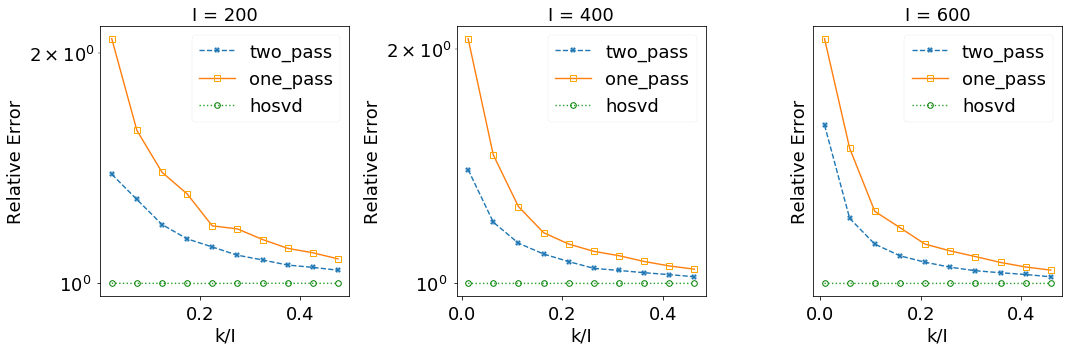

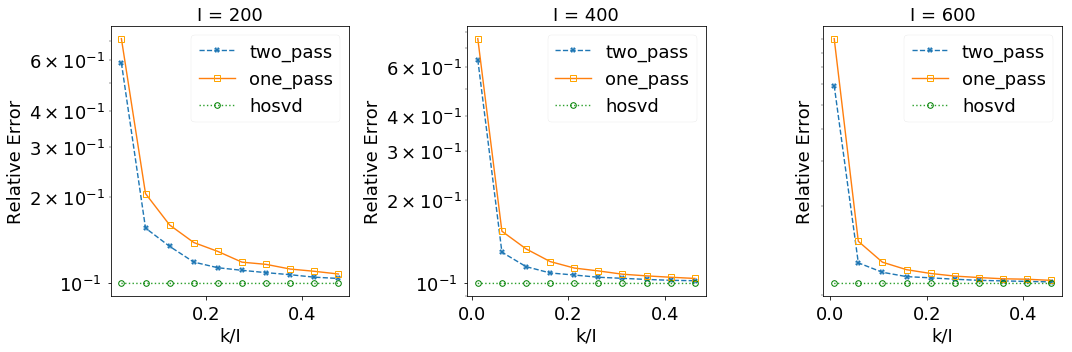

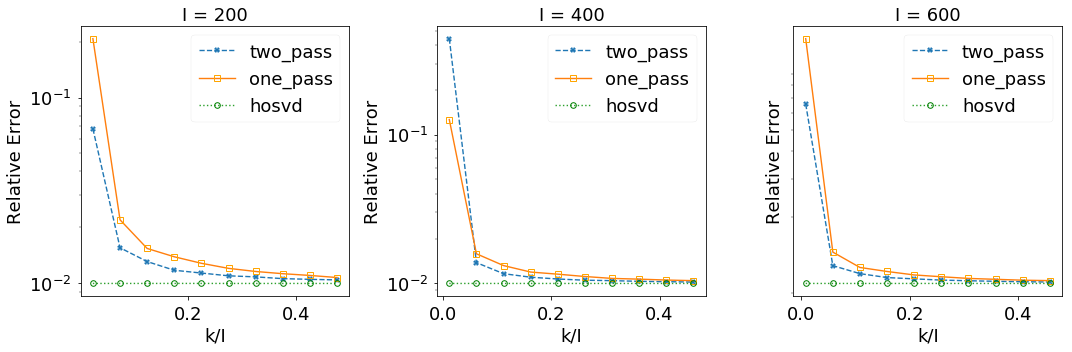

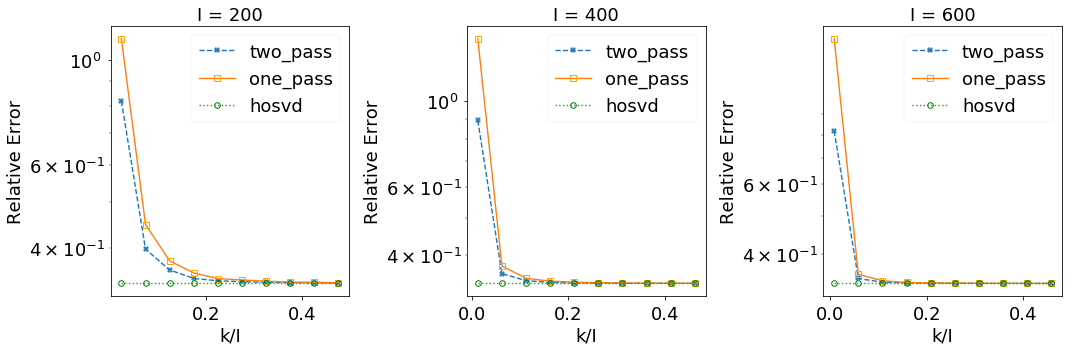

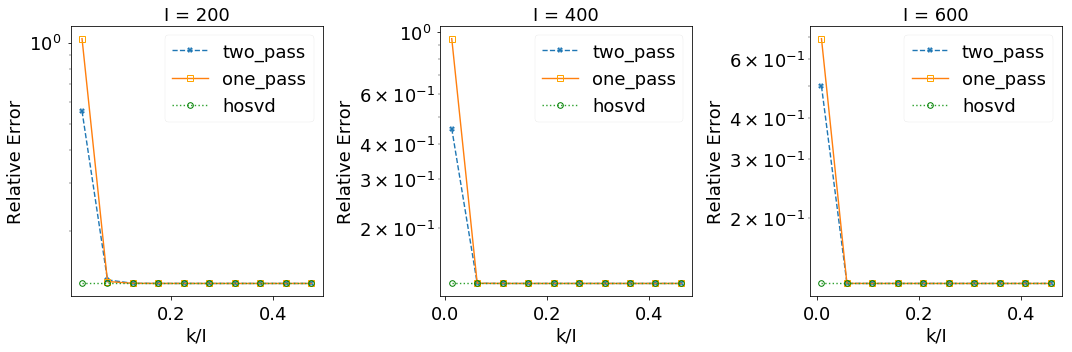

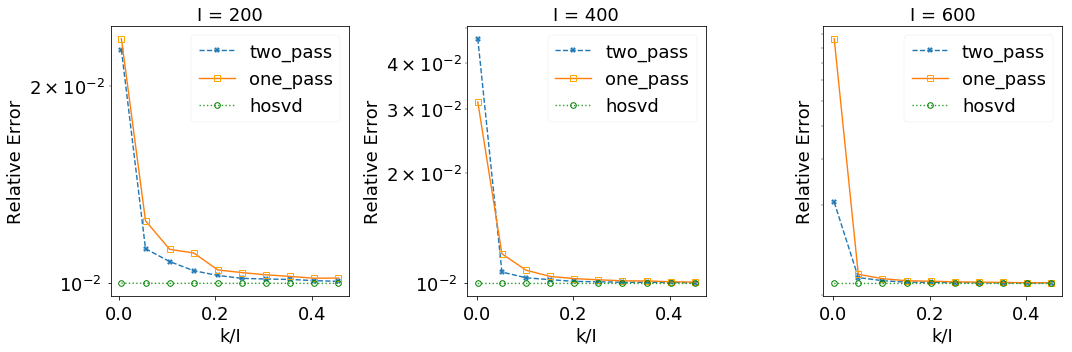

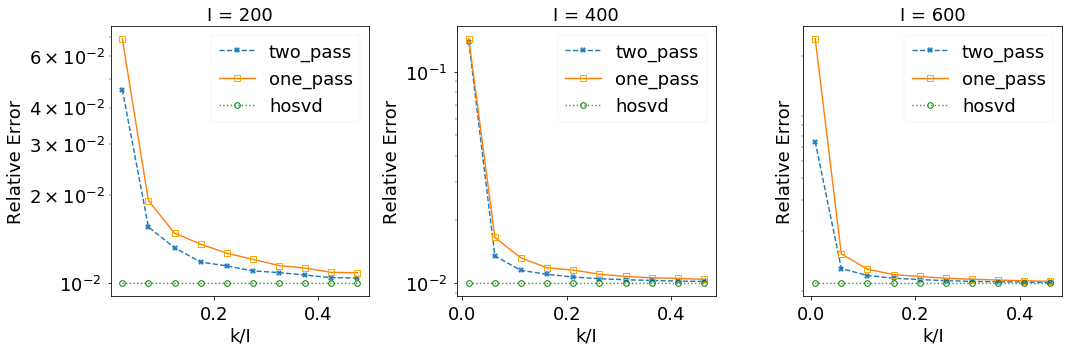

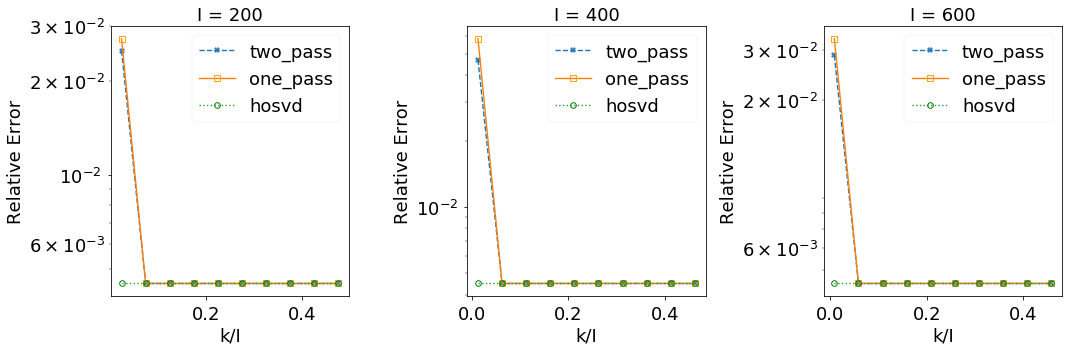

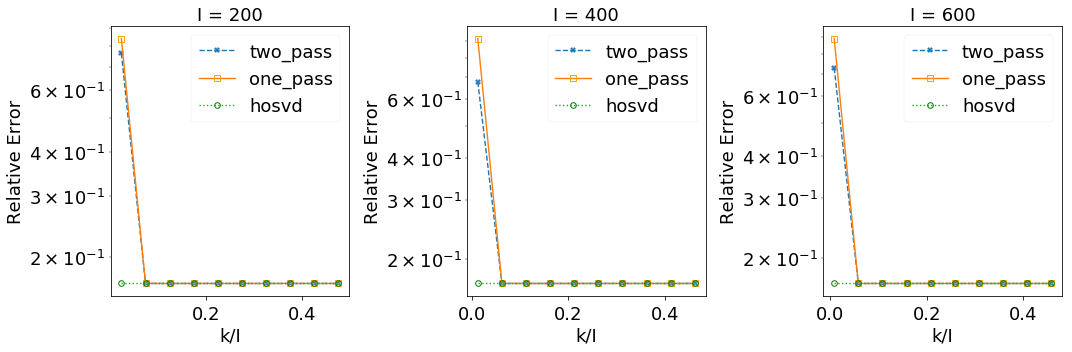

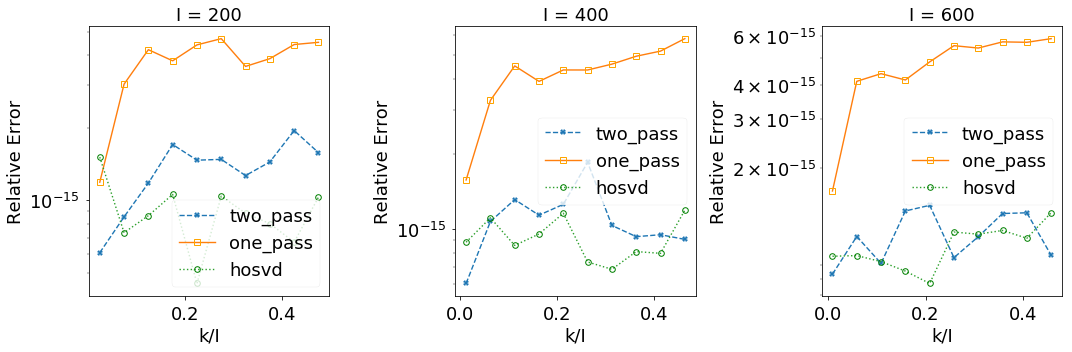

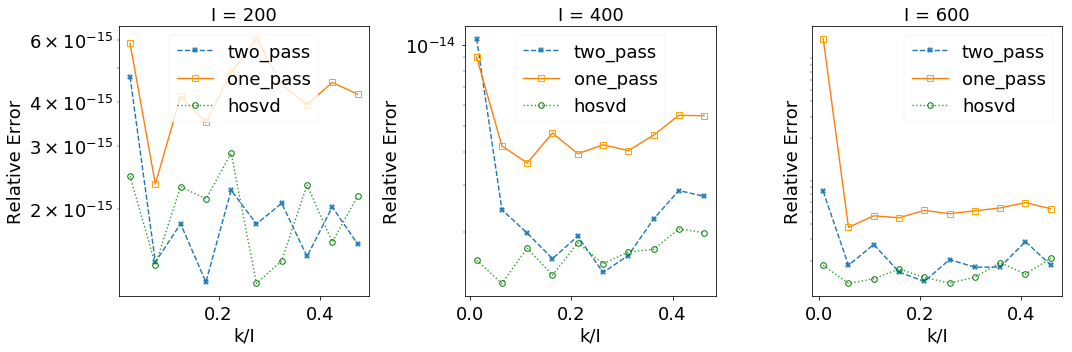

In [126]:
plot_nssim('id',5,1,"id_hnoise.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('id',5,0.1,"id_mnoise.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('id',5,0.01,"id_lnoise.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('spd',5,0.01,"spd.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('fpd',5,0.01,"fpd.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('id',1,0.01,"id_rk1.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('lk',5,0.01,"lk.pdf",ns = np.arange(200,601,200))
plot_nssim('fed',5,0.01,"fed.pdf",ns = np.arange(200,601,200))
plot_nssim('sed',5,0.01,"sed.pdf",ns = np.arange(200,601,200))

plot_nssim('id',5,0,"id_nonoise.pdf",ns = np.arange(200,601,200), sim_runs = 1)
plot_nssim('lk',5,0,"lk_nonoise.pdf",ns = np.arange(200,601,200), sim_runs = 1)



-1.6363324559950603
-1.6363324559950603
-0.7167820878435837
-0.7167820878435837
0.06497786694980827
0.06497786694980827


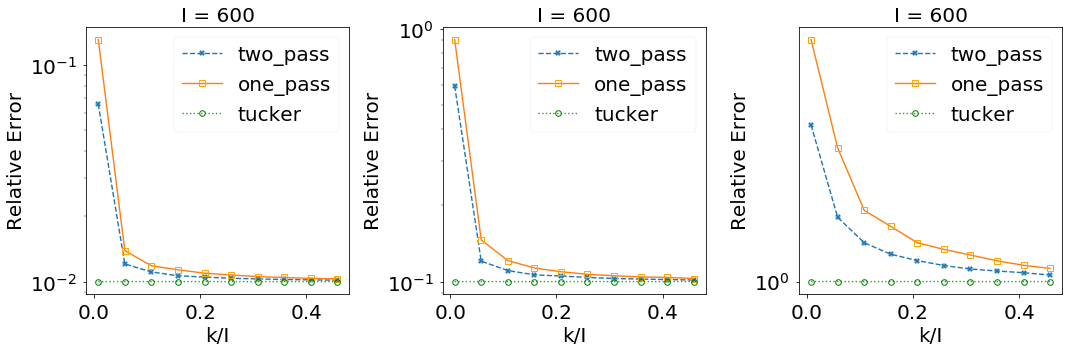

In [109]:
sim_list1 = pickle.load( open( sim_name('id',5,0.01,3)+".pickle", "rb" ) ) 
sim_list2 = pickle.load( open( sim_name('id',5,0.1,3)+".pickle", "rb" ) ) 
sim_list3 = pickle.load( open( sim_name('id',5,1,3)+".pickle","rb"))
fig, ax = plt.subplots(1,3,figsize = (15,5))
sim_list = [sim_list1[2],sim_list2[2],sim_list3[2]]
noise_levels = [0.01,0.1,1]
for plot_id, n in enumerate([600,600,600]): 
    ks =np.arange(5, int(n/2),int(n/20)) 
    ax[plot_id].plot(ks/n,np.mean(sim_list[plot_id][0],0), label = 'two_pass',linestyle = '--',marker = 'X')
    ax[plot_id].plot(ks/n,np.mean(sim_list[plot_id][1],0), label = 'one_pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    ax[plot_id].plot(ks/n,np.mean(sim_list[plot_id][2],0), label = 'tucker', linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
    ax[plot_id].legend(loc = 'best')
    ax[plot_id].set_title("I = %s"%(n))
    ax[plot_id].set_xlabel('k/I')
    ax[plot_id].set_ylabel('Relative Error')
    ax[plot_id].set_yscale('log')
#        ax[plot_id].set_aspect('equal')
    ax[plot_id].title.set_fontsize(20)
    ax[plot_id].xaxis.label.set_fontsize(20)
    ax[plot_id].yaxis.label.set_fontsize(20)
    plt.rc('legend',fontsize = 20)
    plt.rc('xtick', labelsize = 20) 
    plt.rc('ytick', labelsize = 20) 
#    ax[plot_id].yaxis.set_major_locator()
#    ax[plot_id].yaxis.set_major_formatter(ticker.MaxNLocator([str(i) for i in np.arange(1,11,2)*noise_levels[plot_id]]))
    print(np.log10((np.mean(sim_list[plot_id][1]))))
    print(np.log10(np.max(np.mean(sim_list[plot_id][1]))))
    
plt.tight_layout()
plt.savefig('plots/final_plot.pdf')
plt.show()

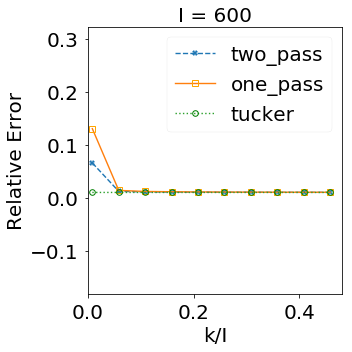

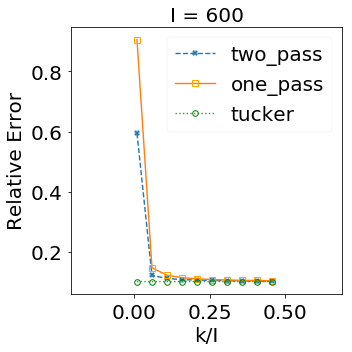

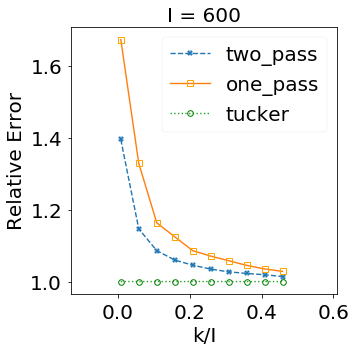

In [138]:
def plot_sim(gen_type,r,noise_level, plot_id, dim = 3, sim_runs = 1,random_seed = 1): 
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim)+".pickle", "rb" ) ) 
    sim = sim_list[plot_id]
    plt.close()
    plt.figure(figsize = (5,5))
    fig, ax = plt.subplots(1,1,figsize = (5,5),squeeze=False)
    ks = np.arange(r, int(n/2),int(n/20)) 
    ax[0,0].plot(ks/n,np.mean(sim[0],0), label = 'two_pass',linestyle = '--',marker = 'X')
    ax[0,0].plot(ks/n,np.mean(sim_list[plot_id][1],0), label = 'one_pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    ax[0,0].plot(ks/n,np.mean(sim_list[plot_id][2],0), label = 'tucker', linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title("I = %s"%(n))
    plt.xlabel('k/I')
    plt.ylabel('Relative Error')
#    plt.yscale('log')
    plt.axis('equal')
    xmin, xmax = plt.xlim()  
    plt.xlim((0, xmax)) 
    ymin, ymax = plt.ylim()
#    plt.ylim((ymin, max(np.mean(sim_list[plot_id][1],0))+noise_level))  
    #ax[0,0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(1,13,3)*noise_levels[plot_id]))
    #ax[0,0].yaxis.set_major_formatter(ticker.FixedFormatter([str(i) for i in np.arange(1,11,2)*noise_levels[plot_id]]))
    ax[0,0].title.set_fontsize(20)
    ax[0,0].xaxis.label.set_fontsize(20)
    ax[0,0].yaxis.label.set_fontsize(20)
    plt.rc('legend',fontsize = 20)
    plt.rc('xtick', labelsize = 20) 
    plt.rc('ytick', labelsize = 20) 
    plt.tight_layout()
    plt.show()
plot_sim('id',5,0.01,2)
plot_sim('id',5,0.1,2)
plot_sim('id',5,1,2)


In [ ]:
run_nssim('id',5,1,np.arange(200,601,200)) 
run_nssim('id',1,0.01,np.arange(200,601,200)) 
run_nssim('spd',5,0.01,np.arange(200,601,200)) 
run_nssim('fpd',5,0.01,np.arange(200,601,200)) 
run_nssim('sed',5,0.01,np.arange(200,601,200)) 
run_nssim('fed',5,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0.01,np.arange(200,601,200)) 
run_nssim('id',1,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0,np.arange(200,601,200))
run_nssim('id',5,1,np.arange(200,601,200)) 
run_nssim('id',5,0.1,np.arange(200,601,200)) 

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b